In [1]:
#Kevin Madden and Aaron Skow
#ECGR 4106/5106 Final Project
#Due Date: 5/13/2022
#Professor: Dr. Hamed Tabkhi, PH.D.

#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from skimage.transform import resize
import os
import torch
import glob
import random
import torch.nn as nn
import torch.optim as op
import torch.nn.functional as F
import datetime
from torchvision import models

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

In [2]:
#To download from kaggle I had to get a json file by making an account
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Download dataset
!kaggle datasets download grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:16<00:00, 93.1MB/s]
100% 1.03G/1.03G [00:16<00:00, 66.3MB/s]


In [7]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [8]:
#Test dataset provided by Dan Rasband
!kaggle datasets download danrasband/asl-alphabet-test

 82% 20.0M/24.3M [00:00<00:00, 38.3MB/s]
100% 24.3M/24.3M [00:00<00:00, 38.8MB/s]


In [9]:
!unzip asl-alphabet-test.zip

Archive:  asl-alphabet-test.zip
  inflating: A/A0001_test.jpg        
  inflating: A/A0002_test.jpg        
  inflating: A/A0003_test.jpg        
  inflating: A/A0004_test.jpg        
  inflating: A/A0005_test.jpg        
  inflating: A/A0006_test.jpg        
  inflating: A/A0007_test.jpg        
  inflating: A/A0008_test.jpg        
  inflating: A/A0009_test.jpg        
  inflating: A/A0010_test.jpg        
  inflating: A/A0011_test.jpg        
  inflating: A/A0012_test.jpg        
  inflating: A/A0013_test.jpg        
  inflating: A/A0014_test.jpg        
  inflating: A/A0015_test.jpg        
  inflating: A/A0016_test.jpg        
  inflating: A/A0017_test.jpg        
  inflating: A/A0018_test.jpg        
  inflating: A/A0019_test.jpg        
  inflating: A/A0020_test.jpg        
  inflating: A/A0021_test.jpg        
  inflating: A/A0022_test.jpg        
  inflating: A/A0023_test.jpg        
  inflating: A/A0024_test.jpg        
  inflating: A/A0025_test.jpg        
  inflating: A/A00

In [10]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [11]:
#Note that the path "aaron_test" must be created because the test set
#initializes in the google colab space without an overarching folder
data_path = '/content/asl_alphabet_train/asl_alphabet_train'
test_data_path = '/content/aaron_test'

#Borrowed this cell to import dataset from online (need to include reference)

train_transforms = transforms.Compose(
[transforms.Resize([128, 128]),
transforms.ToTensor()])
#transforms.Normalize(mean=[0.485, 0.456, 0.406],
#std=[0.229, 0.224, 0.225])])


test_transforms = transforms.Compose(
[transforms.Resize([128, 128]),
transforms.ToTensor()])
#transforms.Normalize(mean=[0.485, 0.456, 0.406],
#std=[0.229, 0.224, 0.225])])
 
data = datasets.ImageFolder(data_path, transform=train_transforms)
num_samples = len(data)
num_samples

87000

In [13]:
#Creating a dataset class for the test data
test_data = datasets.ImageFolder(test_data_path, transform=test_transforms)
num_test_samples = len(test_data)
num_test_samples

870

In [14]:
#Overall Settings
test_size = 0.2
batch_size = 128
num_epoch = 10
learning_rate = 0.01
num_classes = 29

In [15]:
#random seeding of the data
torch.manual_seed(1)
indices = torch.randperm(num_samples)

#Splitting the training and validation data
split = int(num_samples * test_size)
train_dataset = torch.utils.data.Subset(data, indices[split:])
val_dataset = torch.utils.data.Subset(data, indices[:split])

len(train_dataset), len(val_dataset)

(69600, 17400)

In [16]:
#creating data loaders for all 3 sets and establishing a "classes" to reference for webcam testing
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

classes = train_dataloader.dataset.dataset.classes

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Ground truth Y


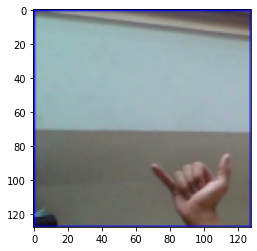

In [17]:
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
#Not necessary to run this code. Only used to see what models are available
dir(models)

['AlexNet',
 'ConvNeXt',
 'DenseNet',
 'EfficientNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'RegNet',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'VisionTransformer',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'convnext',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'efficientnet',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'feature_extraction',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 '

In [18]:
#importing the chosen model
from torchvision.models import densenet121
model = models.densenet121(pretrained=True).to(device=device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [19]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [20]:
#Create training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_dataloader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_dataloader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_dataloader)))

In [21]:
#Making it so that the model resets after training
for param in model.parameters():
    param.requires_grad = False

In [22]:
#Changing the number of outpout classes to 29 to match our set.
#Comiling model
model.classifier = nn.Linear(1024, num_classes)
optimizer = op.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [23]:
#Sanity checks
model.to(device)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [43]:
#Call training loop
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-12 03:14:07.019323 Epoch 1, Training loss 0.5758376718389199
2022-05-12 03:16:13.755028 Epoch 2, Training loss 0.22338034790557096
2022-05-12 03:18:20.431985 Epoch 3, Training loss 0.17036318287308164
2022-05-12 03:20:27.768498 Epoch 4, Training loss 0.1439189173911205
2022-05-12 03:22:35.165609 Epoch 5, Training loss 0.1270514769370065
2022-05-12 03:24:42.203442 Epoch 6, Training loss 0.11520807723761262
2022-05-12 03:26:48.984247 Epoch 7, Training loss 0.10683341303785496
2022-05-12 03:28:56.189451 Epoch 8, Training loss 0.09831272348460249
2022-05-12 03:31:02.887736 Epoch 9, Training loss 0.09263409904943888
2022-05-12 03:33:10.005914 Epoch 10, Training loss 0.08869895270532545


In [44]:
#Create validate loop
def validate(model, train_dataloader, val_dataloader, test_dataloader):
  for name, loader in [("train", train_dataloader), ("val", val_dataloader), ("test", test_dataloader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_dataloader, val_dataloader, test_dataloader)

Accuracy train: 0.98
Accuracy val: 0.97
Accuracy test: 0.28


In [25]:
#Call training loop with more epochs
training_loop(
    n_epochs = 60,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-12 13:34:10.755823 Epoch 1, Training loss 0.5758376718389199
2022-05-12 13:36:19.206273 Epoch 2, Training loss 0.22338034790557096
2022-05-12 13:38:27.119894 Epoch 3, Training loss 0.17036318287308164
2022-05-12 13:40:35.305106 Epoch 4, Training loss 0.1439189173911205
2022-05-12 13:42:43.262337 Epoch 5, Training loss 0.1270514769370065
2022-05-12 13:44:51.175073 Epoch 6, Training loss 0.11520807723761262
2022-05-12 13:46:58.590050 Epoch 7, Training loss 0.10683341303785496
2022-05-12 13:49:06.237778 Epoch 8, Training loss 0.09831272348460249
2022-05-12 13:51:13.451688 Epoch 9, Training loss 0.09263409904943888
2022-05-12 13:53:21.100020 Epoch 10, Training loss 0.08869895270532545
2022-05-12 13:55:28.558759 Epoch 11, Training loss 0.08471564630128663
2022-05-12 13:57:36.613282 Epoch 12, Training loss 0.08164885813397739
2022-05-12 13:59:43.953438 Epoch 13, Training loss 0.07860358333667083
2022-05-12 14:01:50.918741 Epoch 14, Training loss 0.07607194874093265
2022-05-12 14:03:5

In [26]:
#Create validate loop
def validate(model, train_dataloader, val_dataloader, test_dataloader):
  for name, loader in [("train", train_dataloader), ("val", val_dataloader), ("test", test_dataloader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_dataloader, val_dataloader, test_dataloader)

Accuracy train: 0.99
Accuracy val: 0.97
Accuracy test: 0.26


In [30]:
#The next few cells make use of the webcam in google colab.
#Link to original reference code
#https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=ilLkpcKanPRb
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [31]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [32]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
 
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


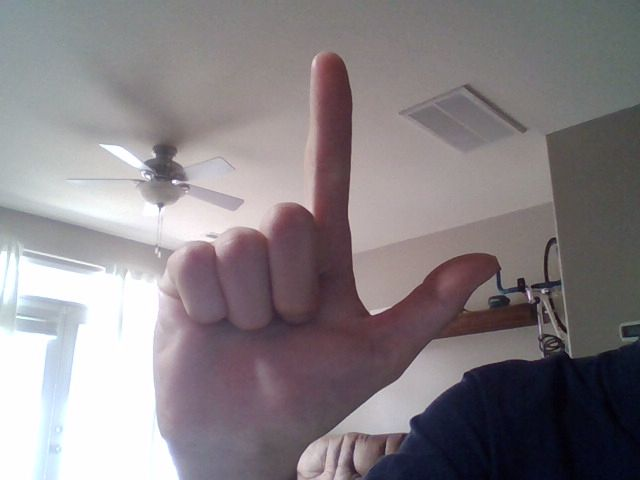

In [33]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [34]:
#importing the image into google colab and showing it
from google.colab.patches import cv2_imshow
testImage = cv2.imread('/content/photo.jpg')

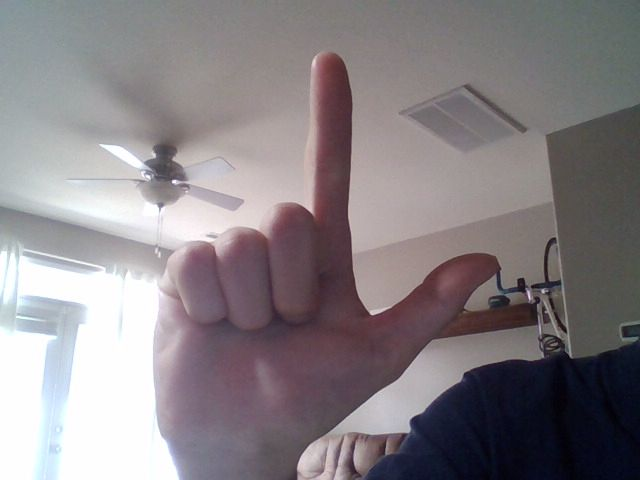

In [35]:
cv2_imshow(testImage)

In [36]:
#converting the webcam image into the proper format and then pre-processing it
#in the way that we have pre-processed the training and validation data
from PIL import Image
from matplotlib import cm
from PIL import Image
import numpy as np
new_im = Image.fromarray(testImage)

preprocess = transforms.Compose(
[transforms.Resize([128, 128]),
transforms.ToTensor()])
#transforms.Normalize(mean=[0.485, 0.456, 0.406],
          #std=[0.229, 0.224, 0.225])])

# Convert the image to PyTorch tensor
tensor = preprocess(new_im)

# print the converted image tensor
print(tensor)

tensor([[[0.6078, 0.6078, 0.5922,  ..., 0.3961, 0.3882, 0.3804],
         [0.6039, 0.6039, 0.6000,  ..., 0.4000, 0.3922, 0.3843],
         [0.6078, 0.6000, 0.6000,  ..., 0.3922, 0.3922, 0.3882],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.1059, 0.1020, 0.0941],
         [0.9961, 0.9961, 0.9961,  ..., 0.1098, 0.1098, 0.0980],
         [0.9961, 0.9961, 0.9961,  ..., 0.1098, 0.1020, 0.0902]],

        [[0.5725, 0.5804, 0.5804,  ..., 0.4000, 0.3961, 0.3843],
         [0.5882, 0.5843, 0.5843,  ..., 0.4039, 0.4000, 0.3961],
         [0.5922, 0.5882, 0.5843,  ..., 0.4118, 0.4039, 0.4000],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.0392, 0.0392, 0.0353],
         [0.9961, 0.9961, 0.9961,  ..., 0.0353, 0.0353, 0.0314],
         [0.9961, 0.9961, 0.9961,  ..., 0.0353, 0.0314, 0.0314]],

        [[0.5333, 0.5216, 0.5137,  ..., 0.3569, 0.3529, 0.3451],
         [0.5255, 0.5294, 0.5294,  ..., 0.3686, 0.3529, 0.3412],
         [0.5294, 0.5373, 0.5412,  ..., 0.3765, 0.3608, 0.

In [37]:
#Code used from HW0 to obtain our model's selected class
batch_t = torch.unsqueeze(tensor, 0)
batchDevice = batch_t.to(device)

In [38]:
out = model(batchDevice)

In [39]:
out

tensor([[-0.0418, -1.4653, -0.1784, -0.2994,  0.3147, -0.9444, -0.0538, -0.1015,
          1.9646, -0.1070, -0.4386,  1.4198, -0.1008, -1.5472, -0.9960, -0.8730,
         -0.5362,  1.6420,  1.0060,  2.0678,  1.2171,  1.2742, -1.7121,  1.1790,
          1.0442, -0.7106, -0.3632, -1.5501, -0.9421]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [40]:
#loading the 29 labels, which are uploaded to the drive in this case
with open('/content/signLanguage_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

In [41]:
_, index = torch.max(out, 1)

In [42]:
#using the index to find the highest scoring label
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

("19: 'T',", 15.060901641845703)